# TDAチュートリアル3：時系列解析への応用

このノートではGUDHIを使って時系列解析を行う基本的なやり方を説明する．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import csv
import random
%matplotlib inline

## データのダウンロードと整備
以下のURLから二つのデータセットのファイルSET A (Z.zip) と SET B (O.zip) をダウンロード・展開して，このノートブックと同じディレクトリに配置する．

http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3

出典：Andrzejak RG, Lehnertz K, Rieke C, Mormann F, David P, Elger CE (2001) Indications of nonlinear deterministic and finite dimensional structures in time series of brain electrical activity: Dependence on recording region and brain state, Phys. Rev. E, 64, 061907

SET Aは眼が閉じている状態の脳波 (EEG) の信号データでありSET Bは眼が開いている状態の脳波信号である．このデータセットでは各患者から眼の開閉に応じて長さ101の脳波信号を6つ計測し，それらを2:1の割合で訓練データとテストデータに分割する．

In [2]:
CLOSE = []
for i in range(1,101):
    string = str(i).zfill(3)
    tmp = np.loadtxt('./Z/Z'+string+'.txt', delimiter=",")
    for j in range(6):
        CLOSE.append(tmp[j*101:(j+1)*101])
OPEN = []
for i in range(1,101):
    string = str(i).zfill(3)
    tmp = np.loadtxt('./O/O'+string+'.txt', delimiter=",")
    for j in range(6):
        OPEN.append(tmp[j*101:(j+1)*101])     

In [3]:
eye_close = np.array(CLOSE)
eye_open = np.array(OPEN)

In [4]:
l0 = list(range(600))
random.shuffle(l0)
l1 = list(range(600))
random.shuffle(l1)

In [5]:
eeg_train = np.concatenate([eye_close[l0[0:400],:],eye_open[l1[0:400],:]])
eeg_test = np.concatenate([eye_close[l0[400:600],:],eye_open[l1[400:600],:]])

In [6]:
# 既に整備してあるデータを使うには以下
# eeg_train = np.loadtxt("eeg_train.csv", delimiter=',')
# eeg_test = np.loadtxt("eeg_test.csv", delimiter=',')

訓練データを確認する．眼が開いている状態と閉じている状態の二つの脳波の例も表示してみる．

In [7]:
eeg_train.shape

(800, 101)

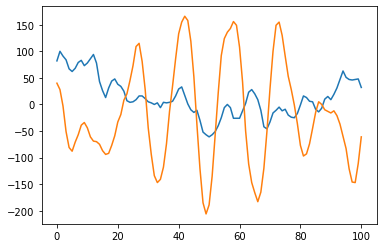

In [8]:
signal_open = eeg_train[100,:]
signal_closed = eeg_train[500,:]
plt.plot(signal_open)
plt.plot(signal_closed)

## 時間遅れ埋め込みとパーシステンス図出力
ここでは時系列を時間遅れ埋め込みして点群を構成し，そこからTDAを使ってパーシステンス図を出力してみよう．

時間遅れ埋め込みの機能もクラス`TimeDelayEmbedding`としてGUDHIに搭載されている．引数としては埋め込み先の次元・遅れ・スキップを指定する．ここでは単に3次元に遅れ・スキップを1として埋め込んでみよう．

In [9]:
import gudhi
import gudhi.point_cloud.timedelay
import gudhi.representations

In [10]:
TDE = gudhi.point_cloud.timedelay.TimeDelayEmbedding(dim=3, delay=1, skip=1)
pts_list = TDE.transform(eeg_train)

時間遅れ埋め込みはnumpy配列の（時系列の個数分の長さを持つ）リストである．各配列は`dim`次元の空間に埋め込まれた点群である．

In [11]:
len(pts_list), pts_list[0].shape

(800, (99, 3))

In [12]:
pts_list[300]

array([[-31., -16.,  10.],
       [-16.,  10.,  28.],
       [ 10.,  28.,  31.],
       [ 28.,  31.,   8.],
       [ 31.,   8., -21.],
       [  8., -21., -50.],
       [-21., -50., -67.],
       [-50., -67., -59.],
       [-67., -59., -44.],
       [-59., -44., -34.],
       [-44., -34., -35.],
       [-34., -35., -29.],
       [-35., -29., -22.],
       [-29., -22., -13.],
       [-22., -13.,  -6.],
       [-13.,  -6.,   3.],
       [ -6.,   3.,  -2.],
       [  3.,  -2., -13.],
       [ -2., -13., -15.],
       [-13., -15., -12.],
       [-15., -12.,   4.],
       [-12.,   4.,  12.],
       [  4.,  12.,  17.],
       [ 12.,  17.,   8.],
       [ 17.,   8.,  -8.],
       [  8.,  -8.,  -5.],
       [ -8.,  -5.,   0.],
       [ -5.,   0.,  13.],
       [  0.,  13.,  32.],
       [ 13.,  32.,  52.],
       [ 32.,  52.,  57.],
       [ 52.,  57.,  63.],
       [ 57.,  63.,  53.],
       [ 63.,  53.,  33.],
       [ 53.,  33.,  -1.],
       [ 33.,  -1., -22.],
       [ -1., -22., -23.],
 

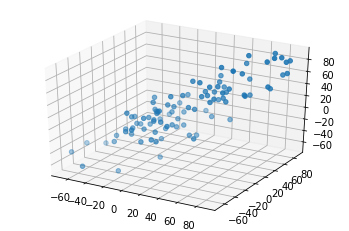

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_list[300][:,0], pts_list[300][:,1], pts_list[300][:,2])
plt.show()

ここからパーシステンス図を計算して出力してみよう．点の個数が100程度ならばRipsフィルトレーションで計算できる．

In [14]:
rips300 = gudhi.rips_complex.RipsComplex(pts_list[300])
st300 = rips300.create_simplex_tree(2)
diag300 = st300.persistence()
diag300

[(1, (23.0, 31.670175244226233)),
 (1, (11.445523142259598, 17.204650534085253)),
 (1, (14.730919862656235, 18.841443681416774)),
 (1, (12.24744871391589, 15.7797338380595)),
 (1, (44.395945760846224, 47.92702786528704)),
 (1, (9.055385138137417, 12.24744871391589)),
 (1, (22.045407685048602, 25.13961017995307)),
 (1, (12.083045973594572, 14.798648586948742)),
 (1, (15.165750888103101, 17.663521732655695)),
 (1, (18.138357147217054, 20.248456731316587)),
 (1, (11.224972160321824, 12.68857754044952)),
 (1, (7.681145747868608, 9.055385138137417)),
 (1, (10.344080432788601, 11.180339887498949)),
 (1, (9.539392014169456, 10.295630140987)),
 (1, (10.862780491200215, 11.489125293076057)),
 (1, (12.449899597988733, 13.0)),
 (1, (11.74734012447073, 12.24744871391589)),
 (1, (16.76305461424021, 17.029386365926403)),
 (1, (9.0, 9.055385138137417)),
 (0, (0.0, inf)),
 (0, (0.0, 34.55430508634199)),
 (0, (0.0, 24.535688292770594)),
 (0, (0.0, 24.041630560342615)),
 (0, (0.0, 21.354156504062622)),


チュートリアル1で説明したやりかたでパーシステンス図を表示してみよう．

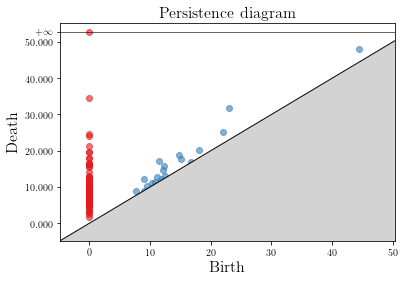

In [15]:
gudhi.persistence_graphical_tools.plot_persistence_diagram(diag300)

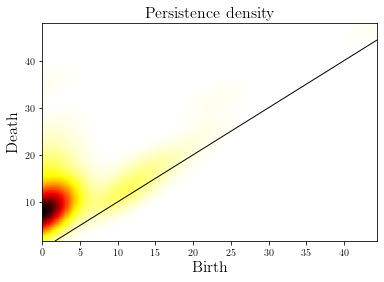

In [16]:
gudhi.persistence_graphical_tools.plot_persistence_density(diag300)

チュートリアル2で見たように`persistence_intervals_in_dimension`を使うことでパーシステンス図をn x 2のnumpy配列として得ることができる．

In [17]:
diag300_0 = st300.persistence_intervals_in_dimension(0)
diag300_1 = st300.persistence_intervals_in_dimension(1)

In [18]:
diag300_0

array([[ 0.        ,  1.73205081],
       [ 0.        ,  2.44948974],
       [ 0.        ,  3.        ],
       [ 0.        ,  3.16227766],
       [ 0.        ,  3.74165739],
       [ 0.        ,  4.24264069],
       [ 0.        ,  4.58257569],
       [ 0.        ,  5.09901951],
       [ 0.        ,  5.09901951],
       [ 0.        ,  5.09901951],
       [ 0.        ,  5.09901951],
       [ 0.        ,  5.38516481],
       [ 0.        ,  5.74456265],
       [ 0.        ,  5.83095189],
       [ 0.        ,  5.91607978],
       [ 0.        ,  5.91607978],
       [ 0.        ,  6.        ],
       [ 0.        ,  6.        ],
       [ 0.        ,  6.40312424],
       [ 0.        ,  6.40312424],
       [ 0.        ,  6.40312424],
       [ 0.        ,  6.55743852],
       [ 0.        ,  6.55743852],
       [ 0.        ,  6.70820393],
       [ 0.        ,  7.        ],
       [ 0.        ,  7.        ],
       [ 0.        ,  7.07106781],
       [ 0.        ,  7.07106781],
       [ 0.        ,

In [19]:
diag300_1

array([[ 9.        ,  9.05538514],
       [ 7.68114575,  9.05538514],
       [ 9.53939201, 10.29563014],
       [10.34408043, 11.18033989],
       [10.86278049, 11.48912529],
       [ 9.05538514, 12.24744871],
       [11.74734012, 12.24744871],
       [11.22497216, 12.68857754],
       [12.4498996 , 13.        ],
       [12.08304597, 14.79864859],
       [12.24744871, 15.77973384],
       [16.76305461, 17.02938637],
       [11.44552314, 17.20465053],
       [15.16575089, 17.66352173],
       [14.73091986, 18.84144368],
       [18.13835715, 20.24845673],
       [22.04540769, 25.13961018],
       [23.        , 31.67017524],
       [44.39594576, 47.92702787]])

上の点群とパーシステンス図は眼が閉じている状態の脳波の信号だったが，眼が開いている状態のものも見てみよう．

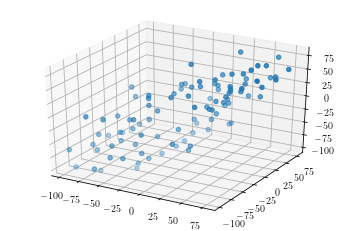

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_list[700][:,0], pts_list[700][:,1], pts_list[700][:,2])
plt.show()

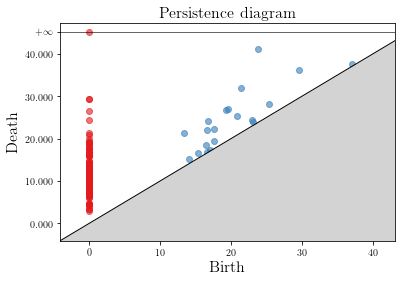

In [21]:
rips700 = gudhi.rips_complex.RipsComplex(pts_list[700])
st700 = rips700.create_simplex_tree(2)
diag700 = st700.persistence()
gudhi.persistence_graphical_tools.plot_persistence_diagram(diag700)

眼が閉じた状態のものと比べてみると点群・パーシステンス図に差が見られると思う．以下ではこのパーシステンス図の差に基づいて分類器を作ってみる．

## ベクトル化とscikit-learnとの組合せ
ここではパーシステンス図をベクトル化してscikit-learnと組み合わせることで分類機を作ることを考えよう．今回は単純にベッチ曲線とランダムフォレストの組合せを試す．

まず，上で説明したフィルトレーション構成・パーシステンス図計算・numpy配列へ変換を一つの関数として設定して，訓練データに関して時間遅れ埋め込みで作られた点群全てのパーシステンス図をnumpy配列として得る．

In [22]:
def rips_diag(X):
    rips = gudhi.rips_complex.RipsComplex(X)
    st = rips.create_simplex_tree(2)
    st.compute_persistence()
    diag0 = st.persistence_intervals_in_dimension(0)[:-1,:] # remove the point with infinite death time
    diag1 = st.persistence_intervals_in_dimension(1)
    return diag0, diag1

In [23]:
list_diags_0 = []
list_diags_1 = []
for ind in range(len(pts_list)):
    diag0, diag1 = rips_diag(pts_list[ind])
    list_diags_0.append(diag0)
    list_diags_1.append(diag1)

クラス`representations.vector_methods.BettiCurve`を使ってベッチ曲線に変換しよう．

In [24]:
Betti0 = gudhi.representations.vector_methods.BettiCurve(20)
Betti1 = gudhi.representations.vector_methods.BettiCurve(20)

In [25]:
Betti0.fit(list_diags_0)
Betti1.fit(list_diags_1)

BettiCurve(resolution=20, sample_range=array([  3.16227766, 216.16660242]))

ベッチ曲線の出力は例えば以下のような1次元のnumpy配列である．

In [26]:
Betti0(list_diags_0[20])

array([98., 42.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

全てのパーシステンス図をベッチ曲線に変換しよう．

In [27]:
betti_curve_0 = Betti0.transform(list_diags_0)
betti_curve_1 = Betti1.transform(list_diags_1)
betti_curve_joint = np.hstack([betti_curve_0, betti_curve_1])

ランダムフォレストにベッチ曲線を与えて分類器を学習しよう．ラベルは前半400が眼が閉じている状態(=0)，後半400が眼が開いている状態(=1)である．

In [28]:
y = np.hstack([np.zeros(400),np.ones(400)])

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(betti_curve_joint, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

この分類器を使ってテストデータを分類してみよう．

In [30]:
pts_test = TDE.transform(eeg_test)

例えばテストデータの0番目の眼が閉じている脳波信号をこの分類器で調べてみる．

In [31]:
diag_test_0, diag_test_1 = rips_diag(pts_test[0])
betti_test0 = np.hstack([Betti0(diag_test_0), Betti1(diag_test_1)])

In [32]:
clf.predict([betti_test0])

array([0.])

最後にこのナイーブな分類器の精度を見てみよう．

In [33]:
list_diags_test_0 = []
list_diags_test_1 = []
for ind in range(len(pts_test)):
    diag0, diag1 = rips_diag(pts_test[ind])
    list_diags_test_0.append(diag0)
    list_diags_test_1.append(diag1)
betti_curve_test_joint = np.hstack([Betti0.transform(list_diags_test_0), Betti1.transform(list_diags_test_1)])

In [34]:
prediction_test = clf.predict(betti_curve_test_joint)

In [35]:
accuracy = np.sum(prediction_test == np.hstack([np.zeros(200),np.ones(200)]))/400
print(accuracy)

0.7725


ここで作った分類器は非常に安直なものなので，あまり精度は良くはない．例えばベッチ曲線とCNNを組み合わせたりなど既存手法にTDA的な特徴量を含めることで精度を良くすることができる場合もある．